---
# Quarterly Pollution Level prediction
---

---
# **Table of Contents**
---

1. [**Importing Libraries**](#Section1)<br>
2. [**Updating Datatype of Sampling Date**](#Section2)<br>
3. [**Data Processing**](#Section3)<br>
  3.1 [**Checking missing values and duplicate records**](#Section31)<br>
  3.2 [**Dropping nan values of RSPM/PM10 and nan on both SO2 and NO2**](#Section32)<br>
  3.3 [**Handling nan values in SO2 and NO2**](#Section33)<br>
4. [**Exploratory Data Analysis**](#Section4)<br>
  4.1 [**Handling the ouliers in SO2,NO2 and RSPM/PM10**](#Section41)<br>
  4.2 [**Boxplot for checking the outliers**](#Section42)<br>
  4.3 [**correlation of SO2,NO2 and PSPM/PM10 values**](#Section43)<br>
5. [**Data Pre-Profiling**](#Section5)<br>
  5.1 [**Hyper Parameter tuning using GridSearchCV**](#Section51)<br>
  5.2 [**Linear Regression**](#Section52)<br>
  5.3 [**Best Random Forest Regressor**](#Section53)<br>
  5.4 [**Best XGBoost Regressor**](#Section54)<br>
6. [**Saving the model**](#Section6)<br>
7. [**Predicting the output**](#Section7)<br>

---

---
<a name = Section1></a>
### Importing all the necessary Libraries
---

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import math
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
import pickle

In [2]:
warnings.filterwarnings("ignore")

In [3]:
pd.set_option("display.max_column",None)
df=pd.read_excel("Airpollution DataSet.xlsx",engine="openpyxl")
df.head()

,Sampling Date,City/Town/Village/Area,SO2,NO2,RSPM/PM10
0,16-06-15,Akola,6.0,6.0,102.0
1,2015-06-07 00:00:00,Akola,5.0,6.0,103.0
2,22-06-15,Akola,6.0,5.0,103.0
3,29-06-15,Akola,6.0,6.0,103.0
4,21-09-15,Akola,6.0,7.0,104.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4736 entries, 0 to 4735
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sampling Date           4736 non-null   object 
 1   City/Town/Village/Area  4736 non-null   object 
 2   SO2                     4530 non-null   float64
 3   NO2                     4692 non-null   float64
 4   RSPM/PM10               4714 non-null   float64
dtypes: float64(3), object(2)
memory usage: 185.1+ KB


---
#### Observation
---
- There are 4 features (sampling Date, City/Town/Village/Area , S02, No2) and RSPM/PM10 is the target label

- Total no. of records is 4736

- Need to update sampling Date datatype to DateTime

- Need to handle missing values in SO2 and NO2

---
<a name = Section2></a>
### Updating datatype of Sampling Date
---

In [5]:
df["Sampling Date"] = pd.to_datetime(df["Sampling Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4736 entries, 0 to 4735
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Sampling Date           4736 non-null   datetime64[ns]
 1   City/Town/Village/Area  4736 non-null   object        
 2   SO2                     4530 non-null   float64       
 3   NO2                     4692 non-null   float64       
 4   RSPM/PM10               4714 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 185.1+ KB


---
<a name = Section3></a>
## Data Processing
---

In [6]:
def Quarters(month):
    if month<=3:
        return "Q1"
    elif (month>3) & (month<=6):
        return "Q2"
    elif (month>6) & (month<=9):
        return "Q3"
    else:
        return "Q4"

In [7]:
df["Quarters"]=df["Sampling Date"].dt.month.apply(lambda x: Quarters(x))
df[df["Sampling Date"].dt.month ==12].head()

,Sampling Date,City/Town/Village/Area,SO2,NO2,RSPM/PM10,Quarters
12,2015-12-10,Akola,6.0,6.0,108.0,Q4
21,2015-12-28,Akola,6.0,8.0,109.0,Q4
30,2015-12-01,Akola,6.0,7.0,111.0,Q4
31,2015-12-14,Akola,6.0,7.0,111.0,Q4
43,2015-12-21,Akola,7.0,8.0,112.0,Q4


#### Number of Areas

In [8]:
print(df["City/Town/Village/Area"].nunique(),df["City/Town/Village/Area"].unique(),sep="\n")

19
['Akola' 'Amravati' 'Aurangabad' 'Chandrapur' 'Jalgaon' 'Jalna' 'Kolhapur'
 'Latur' 'Lote' 'Mumbai' 'Nagpur' 'Nanded' 'Nashik' 'Navi Mumbai' 'Pune'
 'Sangli' 'Solapur' 'Thane' 'Ulhasnagar']


---
<a name = Section31></a>
### Checking missing values and duplicate records
---

In [9]:
df.duplicated().sum()

0

**OBSERVATION**: No duplicate records

In [10]:
df.isnull().sum()

Sampling Date               0
City/Town/Village/Area      0
SO2                       206
NO2                        44
RSPM/PM10                  22
Quarters                    0
dtype: int64

--- 
<a name = Section32></a>
### Dropping nan values of RSPM/PM10 and nan on both SO2 and NO2
---

In [11]:
df.dropna(subset=["RSPM/PM10"],inplace=True)
df.isnull().sum()

Sampling Date               0
City/Town/Village/Area      0
SO2                       205
NO2                        42
RSPM/PM10                   0
Quarters                    0
dtype: int64

In [12]:
df=df[~((df["SO2"].isna())&(df["NO2"].isna()))]

---
<a name = Section33></a>
### Handling nan values in SO2 and NO2
---

- Handling Nan of SO2 and NO2 by replacing it with mean of values of SO2,NO2 respectively one week before and after for that particular area

In [13]:
def handling_nan(df_new,column):
    df_new=df_new.copy()
    #Grouping dataframe with repect to Area
    for area, df_new_area in df_new[df_new[column].isna()].groupby("City/Town/Village/Area"):
        for date in df_new_area["Sampling Date"]:
            # Start date will be one week before the date at which SO2,NO2 is having Nan
            start_date=date-datetime.timedelta(days=7)  
            #Start date will be one week after the date at which SO2,NO2 is having Nan
            end_date=date+datetime.timedelta(days=7)   
            #Calculating Mean for those week for a particular area
            mean_of_two_week=df_new[(df_new["City/Town/Village/Area"]==area)&((df_new["Sampling Date"]>=start_date)&(df_new["Sampling Date"]<=end_date))][column].mean()
            mean_of_month=df_new[(df_new["City/Town/Village/Area"]==area)&(df_new["Sampling Date"].dt.month==date.month)][column].mean()
            #Replacing nan value with mean
            if not (math.isnan(mean_of_two_week)):
                df_new.loc[((df_new["City/Town/Village/Area"]==area)&(df_new["Sampling Date"]==date)),column]=mean_of_two_week
            else:
                df_new.loc[((df_new["City/Town/Village/Area"]==area)&(df_new["Sampling Date"]==date)),column]=mean_of_month
    
    return df_new

In [14]:
df=handling_nan(df,"SO2")
df=handling_nan(df,"NO2")

In [15]:
df.isnull().sum()

Sampling Date             0
City/Town/Village/Area    0
SO2                       0
NO2                       0
RSPM/PM10                 0
Quarters                  0
dtype: int64

- Have handled nan by droping records where RSPM/PM10 had nan and imputed values where SO2, NO2  had ana values

---
<a name = Section4></a>
### Exploratory Data Analysis
---

---
<a name = Section41></a>
#### Handling the ouliers in SO2,NO2 and RSPM/PM10
---

In [17]:
def handling_outliers(df_new,column):
    df_new=df_new.copy()
    for area in df_new["City/Town/Village/Area"].unique():
        #setting max _threshold as 95 percentile
        max_threshold=df_new[df_new["City/Town/Village/Area"]==area][column].quantile(0.90)
        min_threshold=df_new[df_new["City/Town/Village/Area"]==area][column].quantile(0.05)
        drop_index_max=df_new[(df_new["City/Town/Village/Area"]==area) & (df_new[column]>max_threshold)].index
        df_new.drop(index=drop_index_max,axis=0,inplace=True)
        drop_index_min=df_new[(df_new["City/Town/Village/Area"]==area) & (df_new[column]<min_threshold)].index
        df_new.drop(index=drop_index_min,axis=0,inplace=True)
    return df_new

In [18]:
df_updated=handling_outliers(df,"SO2")
df_updated=handling_outliers(df_updated,"NO2")
df_updated=handling_outliers(df_updated,"RSPM/PM10")

In [20]:
df_updated.shape

(3142, 6)

---
<a name = Section42></a>
#### Boxplot for checking the outliers
---

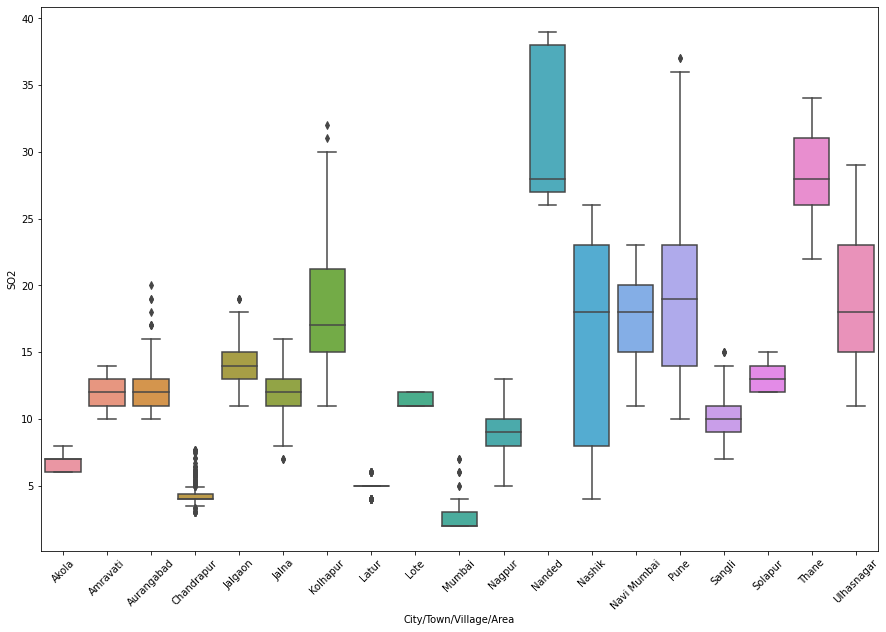

In [76]:
plt.figure(figsize=(15,10))
sns.boxplot(x="City/Town/Village/Area",y="SO2",data=df_updated)
plt.xticks(rotation=45)
plt.show()

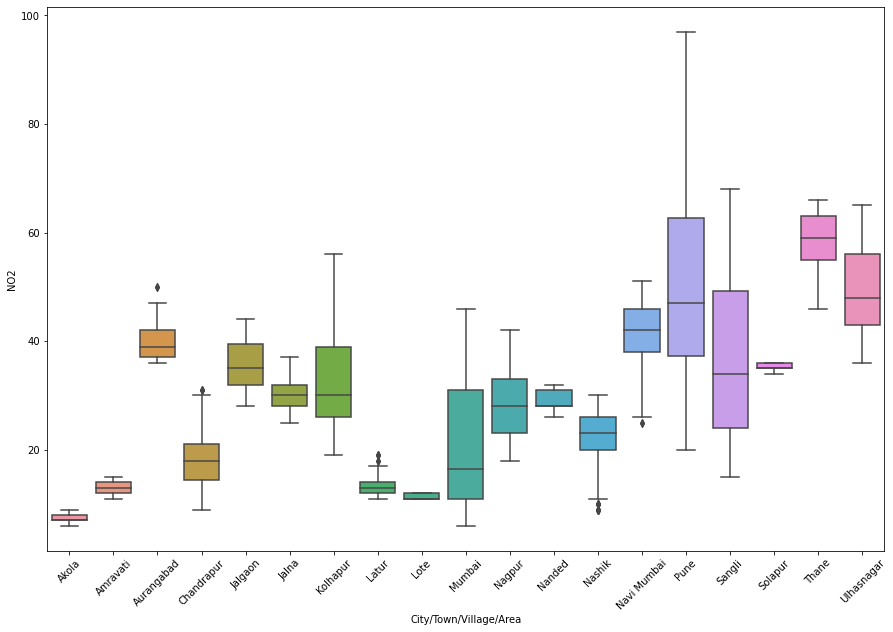

In [47]:
plt.figure(figsize=(15,10))
sns.boxplot(x="City/Town/Village/Area",y="NO2",data=df_updated)
plt.xticks(rotation=45)
plt.show()

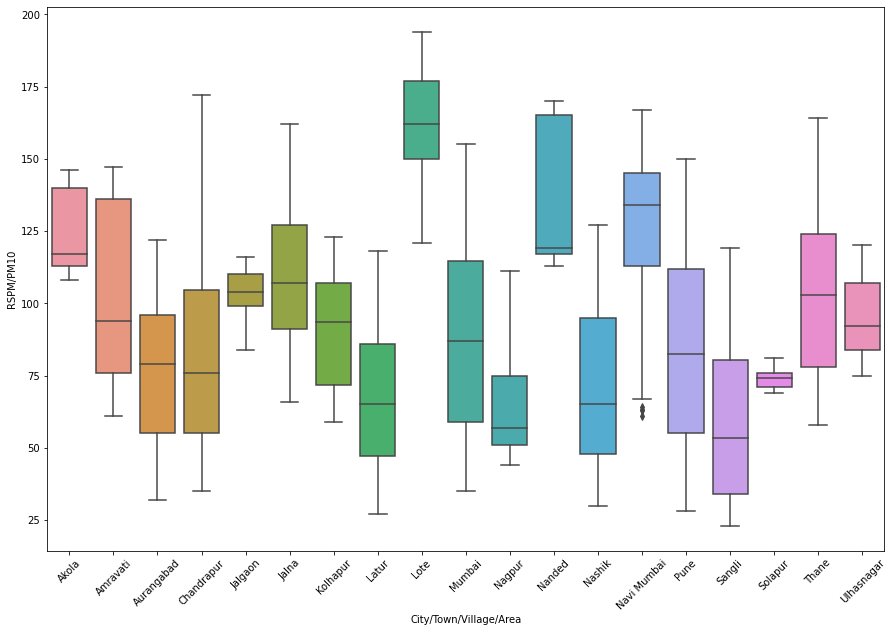

In [46]:
plt.figure(figsize=(15,10))
sns.boxplot(x="City/Town/Village/Area",y="RSPM/PM10",data=df_updated)
plt.xticks(rotation=45)
plt.show()

---
<a name = Section43></a>
#### correlation of SO2,NO2 and PSPM/PM10 values
---

<AxesSubplot:>

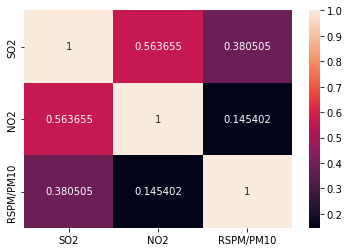

In [48]:
sns.heatmap(df_updated[["SO2","NO2","RSPM/PM10"]].corr(),annot=True,fmt="g")

**OBSERVATION**:SO2 and NO2 are 56 percentage linearly correlated 

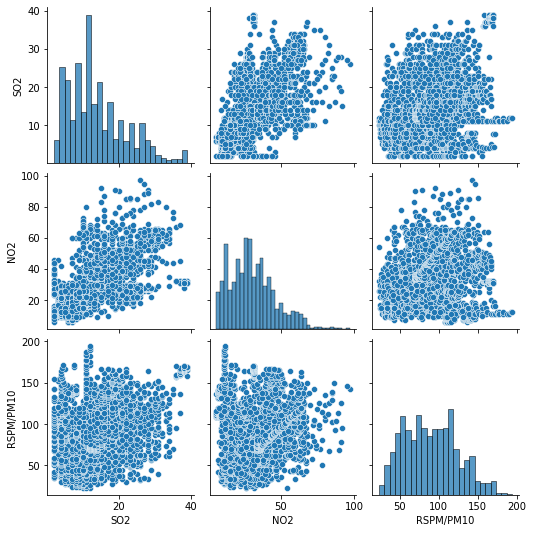

In [25]:
sns.pairplot(df_updated)

---
<a name = Section5></a>
### Building a Model
---

In [26]:
x=df_updated.drop(["Sampling Date","RSPM/PM10"],axis=1)
y=df_updated["RSPM/PM10"]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.15,random_state=12)

In [27]:
cat_cols=x.select_dtypes(include="O").columns.to_list()
num_cols=x.select_dtypes(exclude="O").columns.to_list()

In [28]:
ct=ColumnTransformer([
    ("Step1",StandardScaler(),num_cols),
    ("Step2",OneHotEncoder(sparse=False,handle_unknown="error",drop="first"),cat_cols)
],remainder="drop")

---
<a name = Section51></a>
### Hyper Parameter tuning using GridSearchCV
---

In [30]:
model_params={
    "LinearRegression":{
        "Model":LinearRegression(),
        "Param":{
        }
    },
    "RandomForestRegressor":{
        "Model":RandomForestRegressor(criterion="squared_error"),
        "Param":{
            "model__n_estimators":[250,252,255,258,260],
            "model__max_depth":[11,12,13,14,15,16],
            "model__max_samples":[0.42,0.44,0.46,0.48,0.50],
            "model__min_samples_split":[12,13,14,15,16,17]
        }
    }, 
    "XGB":{
        "Model":XGBRegressor(objective="reg:squarederror",eval_metric="rmse",booster="gbtree"),
        "Param":{
            "model__n_estimators":[290,295,305],
            "model__eta":[0.2,0.22,0.18],
            "model__gamma":[6,7,8],
            "model__max_depth":[5,6,7],
            "model__reg_lambda":[0.7,0.8,0.9],
            "model__reg_alpha":[80,100,120,140]
                 
        }
    }
    
}

In [31]:
results={}
for model_name,params in model_params.items():
    model=params["Model"]
    param=params["Param"]
    clf=Pipeline([
        ("ct",ct),
        ("model",model)
    ])
    Gridcv=GridSearchCV(clf,param_grid=param,cv=5,n_jobs=-1,scoring="neg_mean_squared_error")
    Gridcv.fit(x_train,y_train)
    results[model_name]=Gridcv


---
<a name = Section52></a>
### LinearRegression
---

In [32]:
LR_model=results["LinearRegression"].best_estimator_.fit(x_train,y_train)
print(mean_squared_error(y_train,LR_model.predict(x_train)))

520.4932996689669


In [33]:
print('R2 Score of trained samples is {} '.format(r2_score(y_train,LR_model.predict(x_train))))
print('R2 Score of testing samples is {} '.format(r2_score(y_test,LR_model.predict(x_test))))

R2 Score of trained samples is 0.5556854398510795 
R2 Score of testing samples is 0.5428552979484332 


---
<a name = Section53></a>
### Best Random Forest Regressor
---

In [34]:
results["RandomForestRegressor"].best_params_

{'model__max_depth': 16,
 'model__max_samples': 0.46,
 'model__min_samples_split': 15,
 'model__n_estimators': 258}

In [35]:
RF_model=results["RandomForestRegressor"].best_estimator_.fit(x_train,y_train)
print(mean_squared_error(y_train,RF_model.predict(x_train)))

399.0643578587101


### R2 score of  RF Model

In [36]:
print('R2 Score of trained samples is {} '.format(r2_score(y_train,RF_model.predict(x_train))))
print('R2 Score of testing samples is {} '.format(r2_score(y_test,RF_model.predict(x_test))))

R2 Score of trained samples is 0.6593421956711583 
R2 Score of testing samples is 0.5920761303542841 


---
<a name = Section54></a>
### Best XGBoost Regressor
---

In [37]:
results["XGB"].best_params_

{'model__eta': 0.22,
 'model__gamma': 6,
 'model__max_depth': 5,
 'model__n_estimators': 290,
 'model__reg_alpha': 140,
 'model__reg_lambda': 0.9}

In [38]:
XGB_model=results["XGB"].best_estimator_.fit(x_train,y_train)
print(mean_squared_error(y_train,XGB_model.predict(x_train)))

407.3864463352632


### R2 Score of XGB model

In [39]:
print('R2 Score of trained samples is {} '.format(r2_score(y_train,XGB_model.predict(x_train))))
print('R2 Score of testing samples is {} '.format(r2_score(y_test,XGB_model.predict(x_test))))

R2 Score of trained samples is 0.6522381175142793 
R2 Score of testing samples is 0.5816692955655718 


**Observation**: From this, RandomForestRegressor has better score

---
<a name = Section6></a>
### Saving the model
---

In [49]:
pickle.dump(RF_model,open("model.pkl","wb"))

---
<a name = Section7></a>
### Predicting the output
---

In [72]:
model=pickle.load(open("model.pkl","rb"))
def model_predict(quarter,place,SO2,NO2):
    x_test=pd.DataFrame({"Quarters":[quarter],"City/Town/Village/Area":[place],"SO2":[SO2],"NO2":[NO2]})
    return model.predict(x_test)

In [75]:
output=model_predict("Q2","Akola",5.0,6.0)
print("RSPM/PM10 for the given values is {}".format(output[0]))
# print(type(output))

RSPM/PM10 for the given values is 106.39954288371024
